## IFC Coordinate Reference Systems

The following document attempts to provide a visual enhancement of the original blog written by **Dion Moult**: (https://thinkmoult.com/ifc-coordinate-reference-systems-and-revit.html).  

In addition, users may find the accompanying code useful if they want to learn more about using *IfcOpenShell*.

Special thanks to **Jakob Beetz** for his great work on the original ifcopenshell-notebooks, which can be found here: https://github.com/jakob-beetz/ifcopenshell-notebooks

In [1]:
#First, lets import ifcopenshell and load our IFC file:
import ifcopenshell
file = ifcopenshell.open("data/ifc4 geolocation.ifc")

#### Coordinate systems defined by **IfcProject**:

Let’s talk about what we want the results to be. According to the IFC specification, IfcProject provides the following information:

- the project coordinate system
- the coordinate space dimensions
- the precision used within the geometric representations
- (optionally) the indication of the true north
- (optionally) the map conversion between the project coordinate system and the geospatial coordinate reference system.

This information is provided using the **RepresentationContexts** relationship of the IfcProject. This relationship will contain one or more **IfcGeometricRepresentationContext** elements. Each will typically have a **CoordinateSpaceDimension** of 3, to show a 3D model, and the **Precision** attribute shows the model precision.

Let's see how this is defined in the sample file:

In [2]:
project = file.by_type("IfcProject")[0]

# Let's look at the project attributes first:
project.get_info()

{'id': 23,
 'type': 'IfcProject',
 'GlobalId': '0z0$6As99Fg8k_xxjb4gTX',
 'OwnerHistory': None,
 'Name': 'My Project',
 'Description': None,
 'ObjectType': None,
 'LongName': None,
 'Phase': None,
 'RepresentationContexts': (#21=IfcGeometricRepresentationContext($,'Model',3,1.E-05,#17,$),),
 'UnitsInContext': #4=IfcUnitAssignment((#1,#2,#3))}

In [3]:
# And now specifically the RepresentationContext:
project.RepresentationContexts[0].get_info(recursive=True)

{'id': 21,
 'type': 'IfcGeometricRepresentationContext',
 'ContextIdentifier': None,
 'ContextType': 'Model',
 'CoordinateSpaceDimension': 3,
 'Precision': 1e-05,
 'WorldCoordinateSystem': {'id': 17,
  'type': 'IfcAxis2Placement3D',
  'Location': {'id': 14,
   'type': 'IfcCartesianPoint',
   'Coordinates': (0.0, 0.0, 0.0)},
  'Axis': {'id': 15,
   'type': 'IfcDirection',
   'DirectionRatios': (0.0, 0.0, 1.0)},
  'RefDirection': {'id': 16,
   'type': 'IfcDirection',
   'DirectionRatios': (1.0, 0.0, 0.0)}},
 'TrueNorth': None}

#### The WorldCoordinateSystem attribute
If we dive deeper into **WorldCoordinateSystem** we can find out how the coordinate system for the virtual world is defined:

Usually, this will be set to (0, 0, 0), and represents the origin of the virtual world. In other words, any element in a project usually inherit the local relative placement of its parent, all the way up to **IfcSite**, but somewhere, it needs to end in an absolute coordinate. This **WorldCoordinateSystem** is the final absolute coordinate that is not relative to anything else. It can therefore be used to offset everything in your project, should you want to. The **IfcMapConversion** we just described, will then be used to convert our virtual world into the real world.

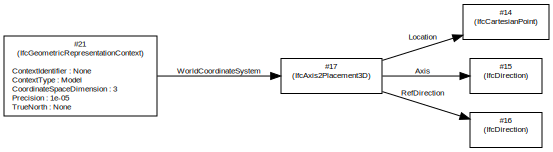

In [4]:
from utils import IfcGraphViz
graph = IfcGraphViz.IfcGraphViz().plot_graph(file, project.RepresentationContexts[0])
graph

In [5]:
# As we can see below, the coordinates (0,0,0) are used for the origin.

project.RepresentationContexts[0].WorldCoordinateSystem.get_info()

{'id': 17,
 'type': 'IfcAxis2Placement3D',
 'Location': #14=IfcCartesianPoint((0.,0.,0.)),
 'Axis': #15=IfcDirection((0.,0.,1.)),
 'RefDirection': #16=IfcDirection((1.,0.,0.))}

#### Project Coordinate System
The actual project coordinate system is defined by the **HasCoordinateOperation** relationship. This holds an *IfcMapConversion* element, with all sorts of useful attributes. Let’s go through them below:
- **SourceCRS**: refers back to the **IfcGeometricRepresentationContext** of the IfcProject to establish the inverse relationship
- **TargetCRS**: refers to the CRS used in the project. This will hold an **IfcCoordinateReferenceSystem**, or its subtype **IfcProjectedCRS** (We'll look at this in more detail below).
- **Eastings**: your IfcProject’s world **IfcGeometricRepresentationContext**’s 0,0,0 origin will correlate to this number. In Sydney, if your building is the Sydney Opera House, this’ll be something like 334902.775. If you have specified a **MapUnit** in the **ProjectedCRS** you should use that unit (e.g. meters). Otherwise, you should use the project units (e.g. millimeters).
- **Northings**: same as Eastings, but for the Y axis. For the Sydney Opera House, it’ll be something like 6252274.139.
- **OrthogonalHeight**: continuing our example, this’ll be the AHD of our world origin. Wikipedia says it is 4m in elevation, so I guess it’ll be something like 4. In this case, we keep the same units as Eastings and Northings, so that we can apply a uniform scale afterwords.
- **XAxisAbscissa**: specifies the local X axis vector along the easting to determine rotation of the local coordinates. If there is no rotation, this will be 1.
- **XAxisOrdinate**: specifies the local X axis vector along the northing to determine rotation of the local coordinates. If there is no rotation, this will be 0.
- **Scale**: Our local (source) coordinate system is usually in millimeters, and the target coordinate system (MGA56) is in meters, so the scale conversion will be something around 0.001. Keep in mind that it is unlikely to be exactly 0.001. This is because the scale isn’t primarily about units, it is the scaling factor of the Helmert transformation, which takes into account curvature of the Earth and local site topograpy. Your surveyor can calculate the actual value.

Let's see what this looks like in our sample file.  First, let's find **HasCoordinateOperation** - This is an inverse attribute of **IfcGeometricRepresentationContext**:

In [6]:
# project
representation_context = project.RepresentationContexts[0]
for key in dir(representation_context):
            if (
                not key[0].isalpha()
                or key[0] != key[0].upper()
                or key in representation_context.get_info()
                or not getattr(representation_context, key)
            ):
                continue
            print(f"{key}: ",getattr(representation_context, key))

HasCoordinateOperation:  (#28=IfcMapConversion(#21,#27,334871.85,6252295.02,12.,2.59808,-1.5,1.),)
HasSubContexts:  (#22=IfcGeometricRepresentationSubContext('Body','Model',*,*,*,*,#21,$,.MODEL_VIEW.,$),)


We know know that IfcMapConversion has an ID of #28, so let's go ahead and visualize this:

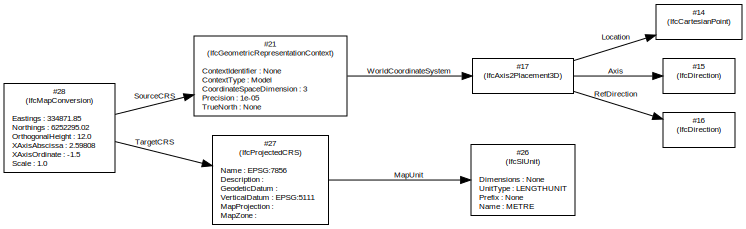

In [7]:
IfcGraphViz.IfcGraphViz().plot_graph(file, file.by_id(28))

This **IfcMapConversion** and **IfcProjectedCRS** element of the **IfcProject**’s **IfcGeometricRepresentationContext** holds all of the georeferencing information that we require. These attributes contains all of the parameters required to perform a “Helmert transformation”, which is a fancy way of saying how to offset, rotate, and scale local project coordinates to a globally positioned coordinate system. For your surveyor to provide these transformation parameters properly, they will need multiple surveyed points (a minimum of two), ideally taken at extremes across the site, in both your local coordinates, as well as their equivalents in the target CRS. They will also need to know your desired building orientation (i.e. project north) to calculate the X axis abcissa and ordinate, and a nominated false origin to set the **Eastings** and **Northings**. The more points that are surveyed, the more accurate this **IfcMapConversion** will become.

With all of the information defined above, to convert from local coordinates (X, Y, Z), to map grid coordinates (X', Y', Z'), you can use these relationships:

![](img/ifcmapconversion-relationship.png)

After all of this information is recorded, it’s interesting to note that the **IfcGeometricRepresentationContext** additionally has a **TrueNorth** attribute. Assuming the **IfcMapConversion** is already provided, there is actually no need for a **TrueNorth** attribute, and so if it is provided, it is merely duplicate data and there for convenience. IFC readers should not parse it and should not apply the same rotation twice. The **IfcMapConversion** takes priority over the **TrueNorth** attribute.

#### **Coordinate system inheritance**
The IfcSite is spatially contained in the IfcProject. However, the spatial containment is not the determining factor for how coordinates are inherited. Instead, the IfcSite has an ObjectPlacement and a Representation attribute. These are the important attributes to pay attention to.  Let's take a closer look in our sample file:

The ObjectPlacement attribute positions the IfcSite element relative to other objects. We will discuss about different placements below, but suffice to say that it merely deals with relative offsets of coordinates.

In [8]:
site = file.by_type("IfcSite")[0]
site.get_info()

{'id': 83,
 'type': 'IfcSite',
 'GlobalId': '2Naya6vn181f_Nk1xMGM7f',
 'OwnerHistory': #20=IfcOwnerHistory(#18,#19,.READWRITE.,.NOTDEFINED.,1589249386,#18,#19,1589249386),
 'Name': 'My Site',
 'Description': None,
 'ObjectType': None,
 'ObjectPlacement': #82=IfcLocalPlacement($,#17),
 'Representation': None,
 'LongName': None,
 'CompositionType': None,
 'RefLatitude': None,
 'RefLongitude': None,
 'RefElevation': None,
 'LandTitleNumber': None,
 'SiteAddress': None}

The **Representation** attribute, however, contains an **IfcRepresentationContext** chosen from the list of contexts defined at the **IfcProject** level. It is this particular selection of the **IfcRepresentationContext** that allows the **IfcSite** to inherit a particular **WorldCoordinateSystem** and **MapConversion** attribute defined at the **IfcProject** level.

I would like to emphasize that the inheritance of coordinate transformation is not done due to spatial containment, but instead due to the selection of **IfcRepresentationContext**. This allows different IfcSite elements to have a different **IfcRepresentationContext**, and therefore have a different MapConversion. This is useful if you are working on a small town or any geographically large projects, as different sites will likely require different Helmert transformations. That said, I have heard talk that the **IfcMapConversion** could be moved to be defined at the **IfcSite** level, instead of the **IfcProject**.

In fact, any IFC product that has a representation can select its own context.  Let's look at our sample model again:

In [19]:
# First, let's load some fancy 3d graphics ;) - Thanks again Jakob Beetz for the code adaptation 😀
from utils.JupyterIFCRenderer import JupyterIFCRenderer
viewer = JupyterIFCRenderer(file, size=(600,500))
viewer

In [15]:
selection = viewer.getSelectedProduct()
selection

#104=IfcWall('2NJ_23i9r0G8LCrcGX2cKW',#20,'Cube',$,$,#95,#103,$,.MOVABLE.)

In [16]:
# We know the wall has an ID of #104, so let's look at the Representation:
wall = file.by_id(104)
representation = wall.Representation
representation

#103=IfcProductDefinitionShape($,$,(#102))

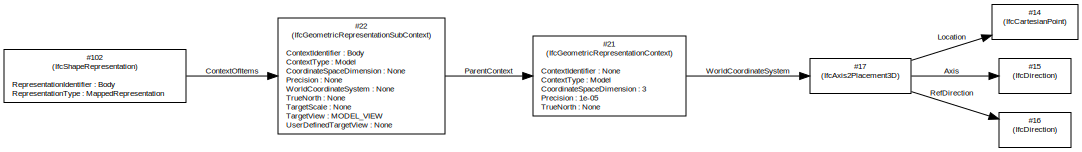

In [17]:
IfcGraphViz.IfcGraphViz().plot_graph(file, representation.Representations[0])

# Notice that the definition of ParentContext below:

#### Coordinate systems defined by IfcSite

In addition to ordinary coordinates, the **IfcSite** provides **RefLatitude**, **RefLongitude**, and **RefElevation** attributes. As the prefix “Ref” suggests, this is a latitude and longitutude provided only for reference. It is not sufficient for proper geolocation and if there is a discrepancy between the **IfcMapConversion** and the data provided in **IfcSite**, the **IfcMapConversion** takes priority.

Note that these **RefLatitude** and **RefLongitude** values are recorded in integers that are separated by a full stop to represent degrees, minutes, seconds, and an optional millionths of a second. West and south locations are negative, and east and north locations are positive.

In a real project, a project may contain multiple **IfcSite** objects. Each **IfcSite** has a **Representation**, which may include terrain, for example. For most projects, there is a site boundary, such as a cadastral boundary which denotes the legal plot of land. The **ObjectPlacement** of the **IfcSite** is therefore likely to be a corner of the site boundary which is a point that has been surveyed.

#### Coordinate systems defined by IfcBuilding
The **IfcBuilding** contains a **Representation** of the building. It also contains an **IfcObjectPlacement**, which is relative to the **IfcSite**. This would place your building on your site model. The rotation of this placement also sets out the project north of the building. If your building has multiple wings, it may also define the individual project norths of each wing.

The **IfcBuilding** additionally contains two attributes:
- ElevationOfRefHeight: as one steps into your building, the finish floor level will be seen as the building’s internal reference height of +0.00. This attribute will record this “+0.00 reference height” in terms of the absolute values of elevation above sea level.
- ElevationOfTerrain: this is the height in absolute values of elevation above sea level of the terrain immediately surrounding the perimeter of the building. If the terrain slopes, it is taken to be the lowest point.

Time to go back to our sample model again:

In [18]:
building = file.by_type("IfcBuilding")[0]
building.get_info()

{'id': 85,
 'type': 'IfcBuilding',
 'GlobalId': '3FllR6gD94WuJroKZKsPAi',
 'OwnerHistory': #20=IfcOwnerHistory(#18,#19,.READWRITE.,.NOTDEFINED.,1589249386,#18,#19,1589249386),
 'Name': 'My Building',
 'Description': None,
 'ObjectType': None,
 'ObjectPlacement': #84=IfcLocalPlacement(#82,#17),
 'Representation': None,
 'LongName': None,
 'CompositionType': None,
 'ElevationOfRefHeight': None,
 'ElevationOfTerrain': None,
 'BuildingAddress': None}

Just like the reference point values in IfcSite, these are also duplications of data. It is not explicitly mentioned, but I believe that should there be a discrepancy, the derived coordinate from the IfcMapConversion takes priority.

The ElevationOfTerrain, apart from being a reference value, also provides a datum to measure the EavesHeight and the Height (total height) of the building which is recorded in the Qto_BuildingBaseQuantities.

#### Absolute coordinates
